# Exoplanet Habitability Analysis

## Introduction
In recent years, thousands of exoplanets (planets outside our Solar System) have been discovered, thanks to missions like **Kepler**, **TESS**, and ongoing ground-based surveys. One of the key questions about these exoplanets is:
> **Which of these worlds could possibly be habitable?**


Ultimately, humanity will either remain confined to Earth or expand into the stars. The first step toward that future is identifying suitable candidate worlds.

The goal of this project is to perform **Exploratory Data Analysis (EDA)** on data from the **NASA Exoplanet Archive** to identify planets with potential habitability.

---
## Dataset
Dataset used in project: **[NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars)** (retrieved August 2025).

---
## Project Goals
- Perform **EDA** on exoplanet characteristics.
- Apply a series of **scientific habitability filters** such as:
  - Equilibrium Temperature and Planet Radius
  - Planet Mass
  - Stellar Spectral Type
  - Distance from Earth
- Use **Visualization** to explain each filtering step.
- Compute **Earth Similarity Score** using a Gaussian-like decay function.
- Create a **radar chart** to compare the final candidate planets to Earth in a meaningful way.

---
## Why It Matters
Understanding which planets might be habitable is one of the **biggest scientific challenges of our time**. This analysis not only highlights the **nearest possible Earth-like worlds**, but also demonstrates the process of filtering raw astronomical data into meaningful insights.

Ultimately, this project is an example of:
- **EDA in practise**
- **Data-driven scientific reasoning**
- **Communicating results visually & narratively**

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dataframe_image as dfi

from matplotlib.patches import Patch

In [4]:
#reading in dataframe from our data
df = pd.read_csv('../data/PSCompPars_2025.08.02.csv', skiprows=35)

print(df.columns)

Index(['pl_name', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2',
       'pl_orbperlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim',
       'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_eqt',
       'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'sy_dist', 'sy_disterr1', 'sy_disterr2'],
      dtype='object')


We have many column titles -> we don't need all of them to determine livability so let's clean it up a little.

In [5]:
#Filter only useful columns
df = df[[
    'pl_name',
    'pl_rade',
    'pl_bmasse',
    'pl_eqt',
    'st_spectype',
    'sy_dist'
]]

print(df.columns)

Index(['pl_name', 'pl_rade', 'pl_bmasse', 'pl_eqt', 'st_spectype', 'sy_dist'], dtype='object')


The NASA dataset uses technical column names. To improve readability, we rename them into descriptive labels.

In [6]:
#Rename columns for readability
df = df.rename(columns={
    'pl_name': 'Planet Name',
    'pl_rade': 'Planet Radius (Earth radii)',
    'pl_bmasse': 'Planet Mass (Earth masses)',
    'pl_eqt': 'Equilibrium Temp (K)',
    'st_spectype': 'Stellar Spectral Type',
    'sy_dist': 'Distance (parsecs)'
})

print(df.columns)

df

Index(['Planet Name', 'Planet Radius (Earth radii)',
       'Planet Mass (Earth masses)', 'Equilibrium Temp (K)',
       'Stellar Spectral Type', 'Distance (parsecs)'],
      dtype='object')


,Planet Name,Planet Radius (Earth radii),Planet Mass (Earth masses),Equilibrium Temp (K),Stellar Spectral Type,Distance (parsecs)
0,11 Com b,12.2,4914.898486,NaN,G8 III,93.1846
1,11 UMi b,12.3,4684.814200,NaN,K4 III,125.3210
2,14 And b,13.1,1131.151301,NaN,K0 III,75.4392
3,14 Her b,12.6,2559.472162,NaN,K0V,17.9323
4,16 Cyg B b,13.5,565.737400,NaN,G3 V,21.1397
...,...,...,...,...,...,...
5962,ups And b,14.0,218.531000,NaN,F8 V,13.4054
5963,ups And c,12.3,4443.241130,NaN,F8 V,13.4054
5964,ups And d,12.5,3257.741172,NaN,F8 V,13.4054
5965,ups Leo b,14.2,162.092488,NaN,G9 III,52.5973


Next, let's do some visualization.

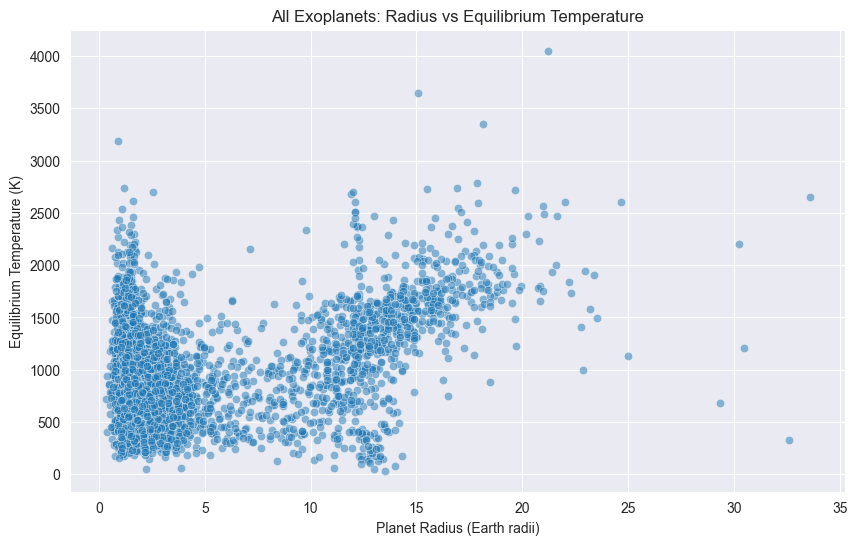

In [7]:
#Plotting scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df,
                x='Planet Radius (Earth radii)',
                y='Equilibrium Temp (K)',
                alpha=0.5 #transperency
                )
plt.title('All Exoplanets: Radius vs Equilibrium Temperature')
plt.xlabel('Planet Radius (Earth radii)')
plt.ylabel('Equilibrium Temperature (K)')
plt.grid(True)

#save plot to figures folder
plt.savefig("radius_vs_equilibrium_temp_scatterplot.png", dpi=300, bbox_inches="tight")
plt.show()

## 1. Equilibrium Temperature & Planet Radius Filter
---
**Equilibrium Temperature:**
**Must be between *180-310 K***
- This range covers the conditions where *liquid water* could exist on the surface.
- It's based on conservative estimates of the habitable zone, accounting for possible greenhouse effects.

**Planet Radius:**
**Must be between *0.5-2.0 Earth radii***
- Most likely the range for a planet to be *rocky and solid surfaced*.
- Planets above 2.0 Earth radii are more likely to be *mini-Neptunes* with thick gas envelopes.
- Below 0.5 Earth radii, a planet may be too small to *retain a substantial atmosphere*.




In [8]:
#Apply filter
habitable_temp_radius = df[
    (df['Equilibrium Temp (K)'] >= 180) & (df['Equilibrium Temp (K)'] <= 310) &
    (df['Planet Radius (Earth radii)'] >= 0.5) & (df['Planet Radius (Earth radii)'] <= 2.0)
]

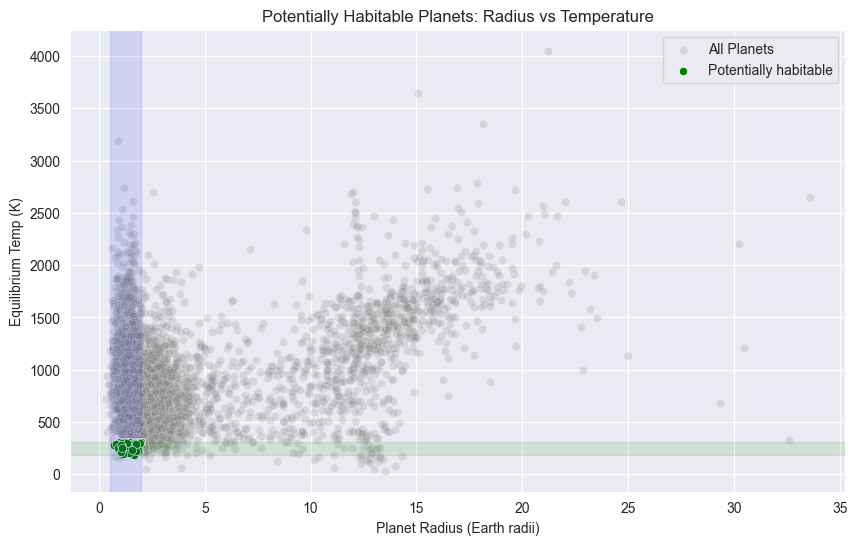

In [9]:
#Visualizing with highlighted subset
plt.figure(figsize=(10, 6))

#Full dataset in grey
sns.scatterplot(
    data=df,
    x='Planet Radius (Earth radii)',
    y='Equilibrium Temp (K)',
    alpha=0.2,
    color='grey',
    label='All Planets'
)

#Highlight potentially habitable ones
sns.scatterplot(
    data=habitable_temp_radius,
    x='Planet Radius (Earth radii)',
    y='Equilibrium Temp (K)',
    color='green',
    label='Potentially habitable'
)

#habitability box
plt.axvspan(0.5, 2.0, color='blue', alpha=0.1)
plt.axhspan(180, 310, color='green', alpha=0.1)

plt.title('Potentially Habitable Planets: Radius vs Temperature')
plt.xlabel('Planet Radius (Earth radii)')
plt.ylabel('Equilibrium Temp (K)')
plt.legend()
plt.grid(True)
plt.savefig("radius_vs_equilibrium_temp_habitable_scatterplot.png", dpi=300, bbox_inches="tight")
plt.show()

Lets calculate the percentage of potentially habitable planets based on the **Equilibrium Temperature & Planet Radius Filter**.

In [10]:
total_planets = len(df)
habitable_planets = len(habitable_temp_radius)

percentage_habitable_filter1 = (habitable_planets / total_planets) * 100


print(f"{habitable_planets} (habitable planets) / {total_planets} (total planets) ")
print(f"{percentage_habitable_filter1:.2f}% potentially habitable (based on radius and temperature ONLY)")

49 (habitable planets) / 5967 (total planets) 
0.82% potentially habitable (based on radius and temperature ONLY)



## Only 49 out of 5967 planets are potentially habitable after just the Equilibrium Temperature & Planet Radius Filter -> Thats **less than 1% (0.82%)**.

In [11]:
habitable_temp_radius

,Planet Name,Planet Radius (Earth radii),Planet Mass (Earth masses),Equilibrium Temp (K),Stellar Spectral Type,Distance (parsecs)
195,GJ 1002 b,1.03000,1.080,230.90,M5.5 V,4.848670
196,GJ 1002 c,1.10000,1.360,181.70,M5.5 V,4.848670
201,GJ 1132 c,1.43000,2.640,300.00,M4.5 V,12.613000
1426,K2-133 e,1.73000,3.640,296.00,M1.5 V,75.170300
1650,K2-288 B b,1.90000,4.270,226.36,M3 V,65.613800
1662,K2-3 d,1.45800,2.200,305.20,M V,44.072700
2240,Kepler-1126 c,1.45000,2.700,305.00,NaN,635.736000
2376,Kepler-1229 b,1.40000,2.540,212.00,NaN,265.482000
2583,Kepler-138 e,0.79700,0.430,292.00,M1 V,66.862400
2596,Kepler-1389 b,1.77000,3.780,300.00,NaN,497.093000


## 2. Planet Mass Filter (M🜨 = Earth Masses)
---
How does **Planet Mass** determine a planets potential to support life?
 - The mass of a planet influences *surface gravity*, *atmospheric retention*, *geological activity*, and more.
---

- **Atmospheric Retention**
  - Planets with low mass (less than 0.5 M🜨) have **weak gravity**. This makes it difficult to retain a substantial atmosphere over geological timescales. Atmospheres are essential for maintaining surface liquid water and protecting life from radiation.
  - Planets with high mass (greater than 5-10 M🜨) may accumulate thick hydrogen-helium envelopes, becoming "mini-Neptunes" that do not have a solid surface.
- **Geological Activity**
  - Adequate mass (>0.5 M🜨) ensures enough internal heating to drive *plate tectonics* and *sustain magnetic fields.*
- **Surface Gravity**
  - Gravity that's **too low** makes it hard for organisms to exist and atmospheres to stay bound.
  - **Too high**, and it will be difficult for complex life to function due to high pressures.
---
### Therefore, our **Planet Mass Range** for habitability: Between 0.5 M🜨 and 10 M🜨

/var/folders/tk/5r6m55jj4hs9xlffbpl_wzz40000gn/T/ipykernel_2347/1425521445.py:13: UserWarning: Glyph 128808 (\N{ALCHEMICAL SYMBOL FOR VERDIGRIS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/tk/5r6m55jj4hs9xlffbpl_wzz40000gn/T/ipykernel_2347/1425521445.py:14: UserWarning: Glyph 128808 (\N{ALCHEMICAL SYMBOL FOR VERDIGRIS}) missing from font(s) Arial.
  plt.savefig("num_planets_vs_mass_barchart.png", dpi=300, bbox_inches="tight")
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128808 (\N{ALCHEMICAL SYMBOL FOR VERDIGRIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


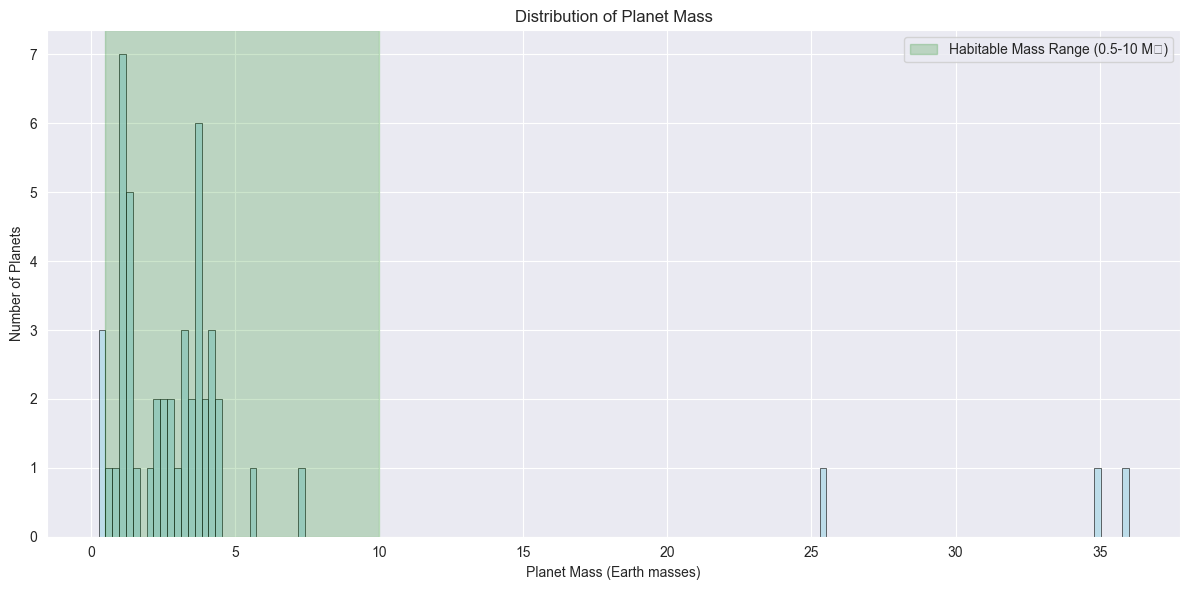

In [12]:
#Visualizing using Bubble Chart
plt.figure(figsize=(12, 6))
sns.histplot(data=habitable_temp_radius, x='Planet Mass (Earth masses)', bins=150, color='lightblue', edgecolor='black')

#Highlight mass range for habitability
plt.axvspan(0.5, 10, color='green', alpha=0.2, label='Habitable Mass Range (0.5-10 M🜨)')

plt.title('Distribution of Planet Mass')
plt.xlabel('Planet Mass (Earth masses)')
plt.ylabel('Number of Planets')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("num_planets_vs_mass_barchart.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
#Apply filter
habitable_mass = habitable_temp_radius[
    (habitable_temp_radius['Planet Mass (Earth masses)'] >= 0.5) & (habitable_temp_radius['Planet Mass (Earth masses)'] <= 10)
]
habitable_mass

print(f"Original number of planets: {len(df)}")
print(f"After equilibrium temp & radius filter: {len(habitable_temp_radius)}")
print(f"After mass filter: {len(habitable_mass)}")
print(f"We are now left with only {(len(habitable_mass) / len(df)) * 100:.3f}% of exoplanets after the planet mass filter")

Original number of planets: 5967
After equilibrium temp & radius filter: 49
After mass filter: 43
We are now left with only 0.721% of exoplanets after the planet mass filter


### We are now left with only 42 out of 5967 exoplanets which is around **0.721%**.

## 3. Stellar Spectral Type Filter
---
Not all stars are equally good for habitability. Most **O (blue giants)**, **B (blue-white stars)**, **A (white stars)** and many **F (yellow-white stars)** are either:
- Too hot
- Too short-lived
- Too volatile (strong solar flares, UV radiation, etc.)

We will focus on:
- **G** (*yellow stars* like our Sun)
  - Lifespan: *~10 billion years*
  - Example: **The Sun (G2V)**
- **K** (*orange dwarfs*)
  - Cooler, more stable lifespan: *~20-30 billion years*
  - Closest Example: **Epsilon Indi A (K5V)**
    - 11.8 light-years from Earth
    - Has binary brown dwarf companion system (Epsilon Indi Ba and Bb)
- **M** (*red dwarfs*)
  - Smallest, coolest, ultra long-lived lifespan: *>100 billion years*
  - Closest Example: **Proxima Centauri (M5.5Ve)**
    - 4.24 light-years from Earth
    - Part of Alpha Centauri star system (Companion to Alpha Centauri A and B) -> a real *three-body problem*



In [14]:
#Listing all spectral types in our data frame
unique_raw_types = df['Stellar Spectral Type'].dropna().unique()
print(f"Found {len(unique_raw_types)} unique spectral type entries:")
print(sorted(unique_raw_types))

Found 313 unique spectral type entries:
['A', 'A1 IV-V', 'A2 V', 'A5', 'A5 V', 'A5-A6', 'A5V', 'A7 V', 'A8', 'A8 III', 'A8 V', 'A8Ve', 'A9/F0', 'Am C', 'B', 'B2 IV', 'B2.5 V', 'B9 IV', 'B9 V', 'B9 Vne', 'B9.5-A0', 'Be9.5/AO', 'DC', 'DQ', 'F', 'F V', 'F0', 'F0 IV', 'F1 V', 'F2', 'F2 V', 'F3', 'F3 V', 'F4', 'F4 V', 'F5', 'F5 IV', 'F5 V', 'F5-F8 V', 'F5V', 'F5V-G0V', 'F6', 'F6 IV', 'F6 IV-V', 'F6 V', 'F7', 'F7 V', 'F7/F8V', 'F7V', 'F8', 'F8 IV', 'F8 IV/V', 'F8 V', 'F8 V CH+0.4', 'F8/G0 IV/V', 'F8/G0 V', 'F9', 'F9 D', 'F9 IV', 'F9 V', 'F9-F9.5', 'F9.5 V', 'F9/G0', 'F9V', 'G', 'G V', 'G0', 'G0 IV', 'G0 V', 'G0 VI', 'G0/1 V', 'G0/2 V', 'G0V', 'G0Vvar', 'G1', 'G1 IV', 'G1 V', 'G1-1.5 V', 'G1.5 V', 'G1/2 V', 'G1V', 'G2', 'G2 IV', 'G2 V', 'G2/3 V', 'G2/3V', 'G2/G3', 'G2/G3 IV/V', 'G2/G3 V', 'G2V', 'G3', 'G3 III', 'G3 IV', 'G3 IV-V', 'G3 IV/V', 'G3 V', 'G3/5 V', 'G3/5V', 'G3/G5 V', 'G3V', 'G4', 'G4 II-III', 'G4 IV', 'G4 V', 'G5', 'G5 III', 'G5 III/IV', 'G5 IV', 'G5 IV/V', 'G5 V', 'G5IV', 'G5V', 

### Raw Spectral Types: Too Much Detail
The `'Stellar Spectral Type'` column contains very detailed classifications such as:
 - G2V
 - F5V-G0V
 - F6 IV
 - ...

These include **temperature subclass**, **luminosity class**, and sometimes even **emission line notations** ('e', 'Ve', etc.).
---
To make analysis tractable, we'll extract only the **primary spectral class** - the **first letter**:
 - 'G2V' -> **G** (Sun-like)
 - 'K51V' -> **K** (Orange dwarf)
 - 'M5.5Ve' -> **M** (Red dwarf)

This gives us a clean set of star categories to work with.


In [15]:
#Data prep: Extract spectral class

#extracting primary spectral class
habitable_mass['Spectral Class'] = habitable_mass['Stellar Spectral Type'].str.upper().str.extract(r'^([OBAFGKM])')

print(habitable_mass['Spectral Class'].value_counts(dropna=False))


Spectral Class
NaN    21
M      20
G       2
Name: count, dtype: int64


/var/folders/tk/5r6m55jj4hs9xlffbpl_wzz40000gn/T/ipykernel_2347/3833087768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  habitable_mass['Spectral Class'] = habitable_mass['Stellar Spectral Type'].str.upper().str.extract(r'^([OBAFGKM])')


In [16]:
habitable_mass

,Planet Name,Planet Radius (Earth radii),Planet Mass (Earth masses),Equilibrium Temp (K),Stellar Spectral Type,Distance (parsecs),Spectral Class
195,GJ 1002 b,1.03000,1.080,230.90,M5.5 V,4.848670,M
196,GJ 1002 c,1.10000,1.360,181.70,M5.5 V,4.848670,M
201,GJ 1132 c,1.43000,2.640,300.00,M4.5 V,12.613000,M
1426,K2-133 e,1.73000,3.640,296.00,M1.5 V,75.170300,M
1650,K2-288 B b,1.90000,4.270,226.36,M3 V,65.613800,M
1662,K2-3 d,1.45800,2.200,305.20,M V,44.072700,M
2240,Kepler-1126 c,1.45000,2.700,305.00,NaN,635.736000,NaN
2376,Kepler-1229 b,1.40000,2.540,212.00,NaN,265.482000,NaN
2596,Kepler-1389 b,1.77000,3.780,300.00,NaN,497.093000,NaN
2628,Kepler-1410 b,1.78000,3.820,290.00,NaN,367.000000,NaN


Lets visualize using a Horizontal Bar Chart

/var/folders/tk/5r6m55jj4hs9xlffbpl_wzz40000gn/T/ipykernel_2347/3706843.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spectral_counts.values,


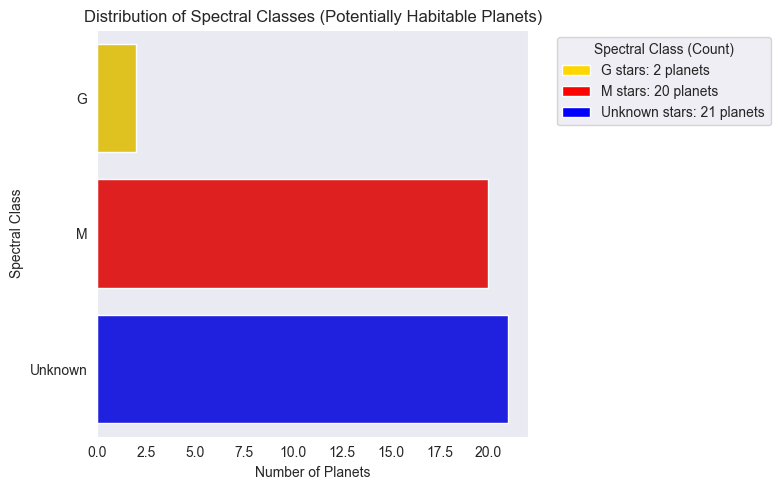

In [17]:

#Count values
spectral_counts = habitable_mass['Spectral Class'].value_counts(dropna=False)

#Renaming NaN for clarity
spectral_counts.index = spectral_counts.index.fillna('Unknown')

#ensure order
desired_order = ['G', 'K', 'M', 'Unknown']
spectral_counts = spectral_counts.reindex([s for s in desired_order if s in spectral_counts.index])

#custom colour palette so star type matches colour
color_map = {
    'G': 'gold',
    'K': 'darkorange',
    'M': 'red',
    'Unknown': 'blue'
}
colors = [color_map[cls] for cls in spectral_counts.index]

#Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=spectral_counts.values,
            y=spectral_counts.index,
            palette=colors)

#creating custom legend with counts
legend_elements = [
    Patch(facecolor=color_map[cls], label=f"{cls} stars: {spectral_counts[cls]} planets")
    for cls in spectral_counts.index
]

plt.legend(handles=legend_elements, title='Spectral Class (Count)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Distribution of Spectral Classes (Potentially Habitable Planets)')
plt.xlabel('Number of Planets')
plt.ylabel('Spectral Class')
plt.grid(axis='x')
plt.tight_layout()
plt.savefig("spectral_class_horizontal_barchart.png", dpi=300, bbox_inches="tight")
plt.show()


### Now that we've visualized the data by **Spectral Class**, we can see that the *first two filters* (based on radius, temperature & mass) has actually removed most of the **unsuitable star systems** - namely those orbiting O, B, A, and F-type stars.
---
One key observation:
> The remaining planets orbit only **M and G type** stars or stars with an **unknown spectral classifications**.
This strongly suggests that the **"Unknown"** entries likely include stars that *could* be M or G types - but we can't confirm this without proper classification.
---
Since we cannot evaluate the unknown stars with confidence, we will **exclude them** from further filtering to maintain scientific reliability.

Our remaining analysis will only include planets orbiting **M and G type stars**.


In [18]:
#Remove rows where spectral Class is NaN (i.e., Unknown)
habitable_spectral = habitable_mass[habitable_mass['Spectral Class'].notna()]

print(f"Original number of planets: {len(df)}")
print(f"After equilibrium temp & radius filter: {len(habitable_temp_radius)}")
print(f"After mass filter: {len(habitable_mass)}")
print(f"After spectral class filter: {len(habitable_spectral)}")
print(f"We are now left with only {(len(habitable_spectral) / len(df)) * 100:.3f}% of exoplanets after the spectral class filter")

Original number of planets: 5967
After equilibrium temp & radius filter: 49
After mass filter: 43
After spectral class filter: 22
We are now left with only 0.369% of exoplanets after the spectral class filter


In [19]:
habitable_spectral

,Planet Name,Planet Radius (Earth radii),Planet Mass (Earth masses),Equilibrium Temp (K),Stellar Spectral Type,Distance (parsecs),Spectral Class
195,GJ 1002 b,1.030,1.080,230.90,M5.5 V,4.84867,M
196,GJ 1002 c,1.100,1.360,181.70,M5.5 V,4.84867,M
201,GJ 1132 c,1.430,2.640,300.00,M4.5 V,12.61300,M
1426,K2-133 e,1.730,3.640,296.00,M1.5 V,75.17030,M
1650,K2-288 B b,1.900,4.270,226.36,M3 V,65.61380,M
1662,K2-3 d,1.458,2.200,305.20,M V,44.07270,M
3702,Kepler-296 f,1.800,3.890,274.00,M2 V,167.00000,M
4064,Kepler-445 d,1.250,2.100,305.00,M4,127.20100,M
4078,Kepler-452 b,1.630,3.290,265.00,G2,551.72700,G
4410,Kepler-69 c,1.710,3.570,299.00,G4 V,730.62500,G


### We are now left with only *22 out of 5967 exoplanets* that have the possibility to sustain life thats: **0.369%**

## 4. Distance (parsecs) Filter
---
Out of 22 potentially habitable planets, let's find out how many are reachable within **100 years travelling at 20% speed of light**.

This distance cutoff is inspired by the **Breakthrough Starshot** initiative -
a $100 million research and engineering program aiming to send an ultra-light spacecraft to nearby stars at 0.2c (20% light speed).

- **Speed:** 0.2 × speed of light = 0.2 light-years per year
- **Time:** 100 years
- **Reachable distance:**

  $$ 0.2 \times 100 = 20 \text{ light-years} \approx 6.13 \text{ parsecs} $$
---
We will filter planets within **6.13 parsecs** to determine which could realistically be targeted by such missions.


In [20]:
#Apply filter
habitable_distance = habitable_spectral[
    (habitable_spectral['Distance (parsecs)'] <= 6.13)
]

print(f"Original number of planets: {len(df)}")
print(f"After equilibrium temp & radius filter: {len(habitable_temp_radius)}")
print(f"After mass filter: {len(habitable_mass)}")
print(f"After spectral class filter: {len(habitable_spectral)}")
print(f"After distance filter: {len(habitable_distance)}")
print(f"We are now left with only {(len(habitable_distance) / len(df)) * 100:.3f}% of exoplanets after the planet distance filter")
print()
print(f"Our final 6 'reachable' habitable planets are: {habitable_distance['Planet Name'].to_list()}")

Original number of planets: 5967
After equilibrium temp & radius filter: 49
After mass filter: 43
After spectral class filter: 22
After distance filter: 6
We are now left with only 0.101% of exoplanets after the planet distance filter

Our final 6 'reachable' habitable planets are: ['GJ 1002 b', 'GJ 1002 c', 'Proxima Cen b', 'Ross 128 b', "Teegarden's Star b", "Teegarden's Star c"]


In [21]:
habitable_distance


,Planet Name,Planet Radius (Earth radii),Planet Mass (Earth masses),Equilibrium Temp (K),Stellar Spectral Type,Distance (parsecs),Spectral Class
195,GJ 1002 b,1.03,1.080,230.9,M5.5 V,4.84867,M
196,GJ 1002 c,1.10,1.360,181.7,M5.5 V,4.84867,M
5054,Proxima Cen b,1.02,1.055,218.0,M5.5 V,1.30119,M
5069,Ross 128 b,1.11,1.400,301.0,M4,3.37454,M
5680,Teegarden's Star b,1.05,1.160,277.0,M7.0 V,3.83078,M
5681,Teegarden's Star c,1.02,1.050,209.0,M7.0 V,3.83078,M


### Our final list of potentially habitable planets within a range of *6.13 parsecs* comes down to **6 planets out of an initial 5967** that's: **0.101%**

## We are going to now going to create a scoring function, calculate similarity scores (exoplanet to earth),
## and visualize our possibly habitable exoplanets stats on a *radar chart* to help our understanding of how comfortable these planets would be for us to live on

In [22]:
#setting up earth reference values
earth_baseline = {
    'Planet Radius (Earth radii)': 1.0,
    'Planet Mass (Earth masses)': 1.0,
    'Equilibrium Temp (K)': 288,
    'Distance (parsecs)': 0
}

#copy and prep data
radar_df = habitable_distance.copy()

### We will use ***Exponential Decay*** to measure similarity
---
1. Calculate the difference: $$\text{diff} = \frac{|\text{value}_{planet} - \text{value}_{earth}|}{\text{value}_{earth}}$$

2. Apply Gaussian-like Scoring: $$\text{score} = e^{-\frac{\text{diff}}{\text{optimal\_range}}}$$

In [23]:

#Normalization approach - how "Earth-like" each value is
def earth_similarity_score(values, earth_val, optimal_range=0.5):
    """Score from 0-1 based on how close to Earth value """
    diff = abs(values - earth_val) / earth_val #we use abs to ensure value is always positive
    return np.exp(-diff / optimal_range) #Gaussian-like scoring


In [24]:
#calculate similarity scores
radar_df['Radius_Score'] = earth_similarity_score(radar_df['Planet Radius (Earth radii)'], 1.0)
radar_df['Mass_Score'] = earth_similarity_score(radar_df['Planet Mass (Earth masses)'], 1.0)
radar_df['Temp_Score'] = earth_similarity_score(radar_df['Equilibrium Temp (K)'], 288)

#distance (closer = better)
max_dist = radar_df['Distance (parsecs)'].max()
radar_df['Distance_Score'] = 1 - (radar_df['Distance (parsecs)'] / max_dist)

### We're going to calculate the ***surface gravity*** so we can better imagine standing on these planets (1.0 same as Earth, 2.0 twice as heavy)
---
Surface gravity formula: $$g = \frac{GM}{r^2}$$

Relative to Earth: $$g_{relative} = \frac{M_{planet}/M_{earth}}{(r_{planet}/r_{earth})^2}$$

Simplified version for our code: $$g_{relative} = \frac{M_{planet}}{r_{planet}^2}$$

In [25]:
#calculate surface gravity for descriptions
radar_df['Surface_Gravity'] = radar_df['Planet Mass (Earth masses)'] / (radar_df['Planet Radius (Earth radii)'] ** 2)

radar_df['Gravity_Score'] = earth_similarity_score(radar_df['Surface_Gravity'], 1)

In [26]:
#features for radar chart
features = ['Gravity_Score', 'Radius_Score', 'Temp_Score', 'Distance_Score']

labels = ['Gravity\nSimilarity', 'Radius\nSimilarity', 'Temperature\nSimilarity', 'Distance\nScore']

In [27]:
#Radar chart function
def plot_all_planets_radar(df):
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1] #complete the circle

    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

    #earth reference (perfect scores)
    earth_values = [1.0] * len(features) + [1.0]
    ax.plot(angles, earth_values, 'o-', linewidth=3, label='Earth (reference)', color='green', markersize=8)
    ax.fill(angles, earth_values, alpha=0.1, color='green')

    #color palette for planets
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

    #plot each planet
    for i, (_, row) in enumerate(df.iterrows()):
        values = row[features].values.tolist()
        values += values[:1] #close loop

        ax.plot(angles, values, 'o-', linewidth=2,
                label=row['Planet Name'], color=colors[i % len(colors)],
                markersize=6)
        ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])

    #customize chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=11)
    ax.tick_params(axis='x', pad=20)
    ax.set_ylim(0, 1.2)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
    ax.grid(True, alpha=0.3)
    #setting radial limits to keep data within 0-1 range but labels further out for clarity
    ax.set_rmax(1.1)  #data stays within 0-1

    plt.title('Exoplanet Habitability Comparison\n(Higher values = More Earth-like)',
              size=16, pad=30)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.tight_layout()
    plt.savefig("radar_chart.png", dpi=300, bbox_inches="tight")
    plt.show()

Note: Originally I calculated the `Habitability_Score` based on the mean of the features on the graph. This would be incorrect as the distance of the planet does not determine how habitable the planet is. Also, including the `Radius_Score` would skew the `Habitability_Score` unfairly as the radius of the planet is already used in determining the `Gravity_Score`.

My final decision is to weigh the `Temp_Score` by a value of 0.65 and the `Gravity_Score` by 0.35, as **temperature directly controls liquid water** -> which is the primary requirement for surface habitability as we understand it.
Even with perfect gravity, a **bad temperature range = no surface oceans**.


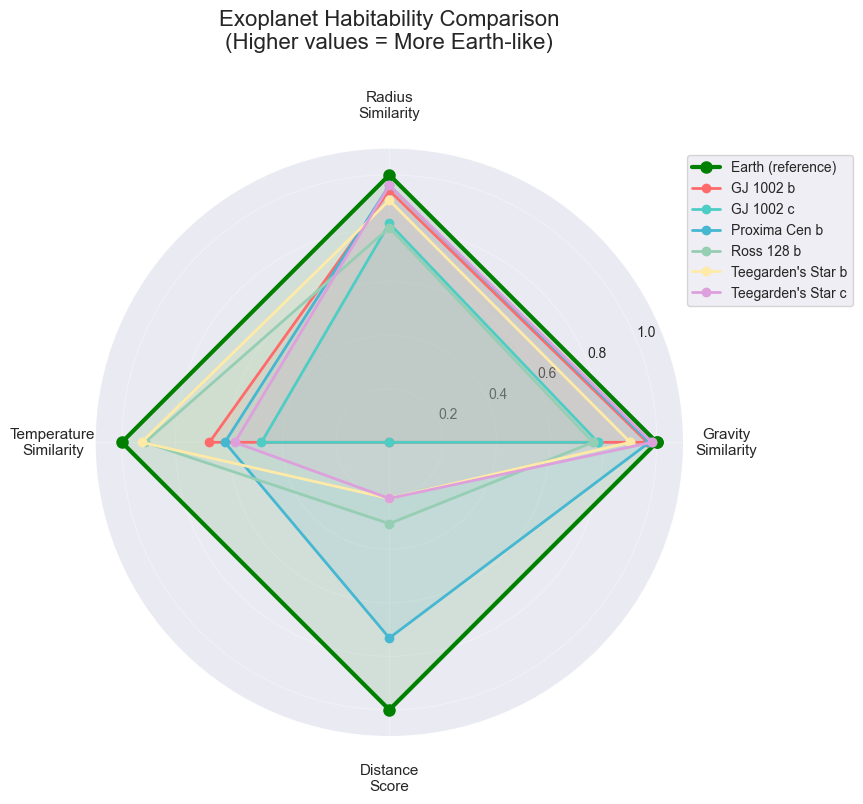

Habitability Scores Summary

1. Teegarden's Star b
   Habitability Score: 0.918
   Surface Gravity: 1.05x Earth
   Estimated Temperature: 4°C
   Distance: 12.5 light years

2. Ross 128 b
   Habitability Score: 0.860
   Surface Gravity: 1.14x Earth
   Estimated Temperature: 28°C
   Distance: 11.0 light years

3. GJ 1002 b
   Habitability Score: 0.775
   Surface Gravity: 1.02x Earth
   Estimated Temperature: -42°C
   Distance: 15.8 light years

4. Proxima Cen b
   Habitability Score: 0.740
   Surface Gravity: 1.01x Earth
   Estimated Temperature: -55°C
   Distance: 4.2 light years

5. Teegarden's Star c
   Habitability Score: 0.719
   Surface Gravity: 1.01x Earth
   Estimated Temperature: -64°C
   Distance: 12.5 light years

6. GJ 1002 c
   Habitability Score: 0.584
   Surface Gravity: 1.12x Earth
   Estimated Temperature: -91°C
   Distance: 15.8 light years



In [28]:
#plot graph
plot_all_planets_radar(radar_df)

#Summary output
print("Habitability Scores Summary")
print("="*50)

#calculate habitability score and sort
radar_df['Habitability_Score'] = (
    0.65 * radar_df['Temp_Score'] +
    0.35 * radar_df['Gravity_Score']
)

sorted_planets = radar_df.sort_values('Habitability_Score', ascending=False)

for i, (_,planet) in enumerate(sorted_planets.iterrows()):
    name = planet['Planet Name']
    overall = planet['Habitability_Score']
    gravity = planet['Surface_Gravity']
    temp_c = planet['Equilibrium Temp (K)'] - 273.15 #convert to celcius
    distance = planet['Distance (parsecs)'] * 3.26 #convert to light years

    print(f"\n{i+1}. {name}")
    print(f"   Habitability Score: {overall:.3f}")
    print(f"   Surface Gravity: {gravity:.2f}x Earth")
    print(f"   Estimated Temperature: {temp_c:.0f}°C")
    print(f"   Distance: {distance:.1f} light years")

print("\n" + "="*50)



In [30]:
#Creating a summary table for export
summary = radar_df[['Planet Name', 'Distance (parsecs)', 'Surface_Gravity', 'Equilibrium Temp (K)', 'Habitability_Score']]

summary = summary.rename(columns={
    'Surface_Gravity': 'Gravity (× Earth)',
    'Equilibrium Temp (K)': 'Temperature (K)',
    'Distance (parsecs)': 'Distance (pc)',
    'Habitability_Score': 'Habitability Score'
})

#save as csv
summary.to_csv("../figures/final_candidates_summary.csv", index=False)
#save as png
dfi.export(summary,"../figures/final_candidates_summary.png", table_conversion='matplotlib')

# Closest Potentially Habitable Planets

We will rank the candidates by **distance from Earth**, since proximity is crucial for exploration and mission feasibility (e.g, *Breakthrough Starshot*).

---

1. **Proxima Centauri b**
   - Distance: **4.2 light years**
   - Habitability Score: **0.740**
   - Surface Gravity: ~**1.01 × Earth**
   - Estimated Temperature: **–55 °C**
   - Closest exoplanet to Earth; stellar flares may pose habitability risks.

2. **Ross 128 b**
   - Distance: **11.0 light years**
   - Habitability Score: **0.860**
   - Surface Gravity: ~**1.14 × Earth**
   - Estimated Temperature: **+28 °C**
   - A quiet red dwarf; warm and potentially comfortable conditions.

3. **Teegarden’s Star b**
   - Distance: **12.5 light years**
   - Habitability Score: **0.918**
   - Surface Gravity: ~**1.05 × Earth**
   - Estimated Temperature: **+4 °C**
   - Very Earth-like; excellent candidate for habitability.

4. **Teegarden’s Star c**
   - Distance: **12.5 light years**
   - Habitability Score: **0.719**
   - Surface Gravity: ~**1.01 × Earth**
   - Estimated Temperature: **–64 °C**
   - Colder sibling of Teegarden’s Star b, but still Earth-like in gravity.

5. **GJ 1002 b**
   - Distance: **15.8 light years**
   - Habitability Score: **0.775**
   - Surface Gravity: ~**1.02 × Earth**
   - Estimated Temperature: **–42 °C**
   - Cold but physically Earth-like; near the outer edge of reachable systems.

6. **GJ 1002 c**
   - Distance: **15.8 light years**
   - Habitability Score: **0.584**
   - Surface Gravity: ~**1.12 × Earth**
   - Estimated Temperature: **–91 °C**
   - Very cold, but still a rocky planet with Earth-like gravity.

# Final Results & Conclusions
After filtering the NASA Exoplanet Archive data through **four filters** (Temperature/Radius, Mass, Spectral Type and Distance) in order to find the **closest reachable systems (≤ 6.13 parsecs / ~20 light-years)**, we are now left with **6 candidate planets**.

| Planet            | Distance (ly) | Habitability Score | Gravity (× Earth) | Est. Temp (°C) |
|-------------------|---------------|---------------------|-------------------|----------------|
| Proxima Cen b     | 4.2           | 0.740               | 1.01              | –55            |
| Ross 128 b        | 11.0          | 0.860               | 1.14              | +28            |
| Teegarden’s Star b| 12.5          | 0.918               | 1.05              | +4             |
| Teegarden’s Star c| 12.5          | 0.719               | 1.01              | –64            |
| GJ 1002 b         | 15.8          | 0.775               | 1.02              | –42            |
| GJ 1002 c         | 15.8          | 0.584               | 1.12              | –91            |
---

## Key Insights
- **Temperature & Gravity are Primary:**
  - Habitability scores weigh temperature more heavily (65%) than surface gravity (35%) because liquid water availability is the primary requirement for life, whereas gravity mainly affects atmospheric retention.
- **Proximity vs Habitability Trade-Off:**
  - **Proxima Centauri b** is the closest to Earth (4.2 ly) but has a lower habitability score due to more extreme temperature.
  - **Teergarden's Star b** has the highest habitability score but is further away (12.5 ly).
- **Surface Gravity:**
  - All six candidates have gravity close to Earth's (1.01-1.14 x Earth), suggesting humans could physically stand on them with minimal adjustment.
- **Estimated Temperature:**
  - Planets range from **-91 ºC** (GJ 1002 c) to **+28 ºC** (Ross 128 b), showing that even rocky, Earth-gravity planets can have very cold climates.

---

## Takeaway
While none of these planets are guaranteed habitable, this analysis demonstrates a **data-driven approach** to:
1. Filter exoplanets scientifically,
2. Rank them by habitability and proximity,
3. Visualize complex astronomical data clearly.

This methodology can be expanded as **new exoplanet data** becomes available or refined with **atmospheric modeling and spectral analysis** for more detailed habitability predictions.

---

## Limitations & Next Steps
- **Equilibrium temperature** does not account for greenhouse effects or atmospheric composition.
- Planet **radius and mass** give only a rough guess of surface composition; internal structure is unknown.
- **Magnetic fields, tectonics, and atmosphere** are not included in this dataset but are crucial for long-term habitability.
- Future work: integrate atmospheric models and spectral data to refine habitability predictions.

---
## Closing Note
This notebook is part of my ongoing **portfolio in data science**.

It demonstrates:
- Exploratory Data Analysis (EDA) on a real scientific dataset (NASA Exoplanet Archive)
- Use of filtering, visualization, and scoring techniques to narrow down candidates for habitability
- Clear communication of complex results in a way that’s both technical and accessible

Feedback and collaboration are welcome!